# Policy gradient methods and application to Carpole environment

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [24]:
out_path = "/content/drive/Othercomputers/My Mac/Google Drive/Colab Notebooks/Reinforcement-learning/outputs/rl-algos/"

In [1]:
import gymnasium as gym
import torch.optim as optim
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.distributions import Categorical, Normal, MultivariateNormal

In [2]:
torch.manual_seed(314)

In [7]:
if torch.backends.mps.is_available():
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

# for now using cpu since policies are small and it worked faster on cpu compared to gpu
# device = "cpu"

# print(device)

# Algorithms implemented
- REINFORCE: Simplest policy optimization algorithm, main issue: high variance in estimates.
- REINFORCE with baseline: Reduces variance by adding basline as a correction factor in episode gains. Baseline used is value-function approximation.
- Actor-critic method: Converts batch baseline approximation to online which results in smaller computational cost.
- Proximal policy optimization (PPO)

# REINFORCE pseudocode

- Generate an episode of length T. From episode we need a series of triplets ($\{S_t, A_t, R_{t+1}\}_t$) to implement REINFORCE.
- Define parametrized policy.
- Update policy parameter: Run SGD for t=0,...,T-1.
    - Compute $G \leftarrow \sum_{i=t+1}^{T} \gamma^{i-t-1}R_i$
    - $\theta_{t+1} \leftarrow \theta_t + \alpha \gamma^t G \nabla \ln \Pi(A_t | S_t, \theta_t)$

In [11]:
class PolicyGradient(nn.Module):
    """
      - Policy definition which is used for all the algorithms
      - Policy prameterization is based on PPO paper "Proximal Policy Optimization Algorithms", Section 6.1
    """

    def __init__(self, p_dim=2, state_dim=4, hidden_dim=64):
        super().__init__()
        self.linear1 = nn.Linear(state_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, p_dim)
        self.tanh = torch.nn.Tanh()

    def forward(self, x):
        x = self.tanh(self.linear1(x))
        x = self.tanh(self.linear2(x))

        return x

    def sample_action(self, probs):
        categorical_dist = Categorical(probs)
        sample = categorical_dist.sample()

        return sample

# Cartpole environment and policy
(ref: https://gymnasium.farama.org/environments/classic_control/cart_pole/)
- Actions: Two actions: move left (0) and move right (1)
- States:
    - Cart position
    - Cart velocity
    - Pole angle
    - Pole angular velocity
- Initial state: all values randomly initialized in the range [-0.05, 0.05]
- Terminal state: Episode length greater than 500 or pole angle > 24deg or < -24deg
- Reward: +1 for each state before we reach a termial state

In [4]:
def gen_episode(env, policy, device):
    """
    Generates an episode until termination in environment 'env' following 'policy'.

    Parameters:
        env (gym environment): object of gym environment.
        policy (object of neural network parametrizing the policy): neural network.

    Returns:
        lists: rewards, logps, states, probs_all.
    """
    done = False
    rewards = []
    logps = []
    states = []
    probs_all = []
    obs, _ = env.reset()
    while not done:
        logits = policy(torch.as_tensor(obs, dtype=torch.float32, device=device))
        probs = torch.softmax(logits, dim=-1)
        # This part is interesting and seems useful to understand
        # https://docs.pytorch.org/docs/stable/distributions.html#torch.distributions.categorical.Categorical
        dist = torch.distributions.Categorical(probs=probs)
        action = dist.sample()
        logps.append(dist.log_prob(action))
        probs_all.append(dist.log_prob(action).exp())
        obs, reward, terminated, truncated, info = env.step(action.item())
        rewards.append(reward)
        states.append(obs)
        done = terminated or truncated
        # done = truncated


    return rewards, logps, states, probs_all

In [5]:
## Leaving a few possible ways to implement here

# def discounted_rewards(rw, discount_factor):
#     R = []
#     for i in range(len(rw)):
#         discounted_reward = 0
#         for j in range(i, len(rw)):
#             discounted_reward += (discount_factor ** (j - i)) * rw[j]
#         R.append(discounted_reward)
#     return R
# def discounted_rewards(rw, discount_factor):
#     R = []
#     for i in range(len(rw)):
#         discounted_reward = (discount_factor ** (np.arange(i, len(rw)) - i)) * rw[i:]
#         R.append(discounted_reward.sum())
#     return R
# def discounted_rewards(rw, discount_factor):
#     R = []
#     temp = np.arange(0, len(rw))
#     for i in range(len(rw)):
#         discounted_reward = (discount_factor ** (temp[i:] - i)) * rw[i:]
#         R.append(discounted_reward.sum())
#     return R
def discounted_rewards(rw, gamma, device):
    rw = torch.as_tensor(rw, dtype=torch.float32, device=device)
    G = torch.empty_like(rw)
    running = 0.0
    for t in reversed(range(len(rw))):
        running = rw[t] + gamma * running
        G[t] = running
    return G


# Cartpole with REINFORCE

In [25]:
import time
env = gym.make("CartPole-v1")
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.n
episodes = 1000
discount_factor = 0.99
total_reward_reinforce = np.zeros(episodes)
sim_runs = 20

for sim in range(sim_runs):
    env.reset(seed=sim)
    policy = PolicyGradient(act_dim, obs_dim)
    policy.to(device)
    optimizer = optim.Adam(policy.parameters(), lr=7e-4)
    returns_hist = []
    for ep in range(episodes):
        rw, logp, _, _ = gen_episode(env, policy, device)
        returns_hist.append(len(rw))
        R = discounted_rewards(rw, discount_factor, device)
        R = (R - R.mean()) / (R.std() + 1e-8)
        logp = torch.stack(logp)
        loss = -(logp * R).sum()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Stop early if solved
        if len(returns_hist) >= 100 and np.mean(returns_hist[-100:]) >= 475:
            total_reward_reinforce[ep:] += 500
            break
        total_reward_reinforce[ep] += len(rw)
    if sim % 5 == 0:
      print(sim)



total_reward_reinforce = total_reward_reinforce / sim_runs
np.save(out_path + "total_reward_reinforce.npy", total_reward_reinforce)

0
5
10
15


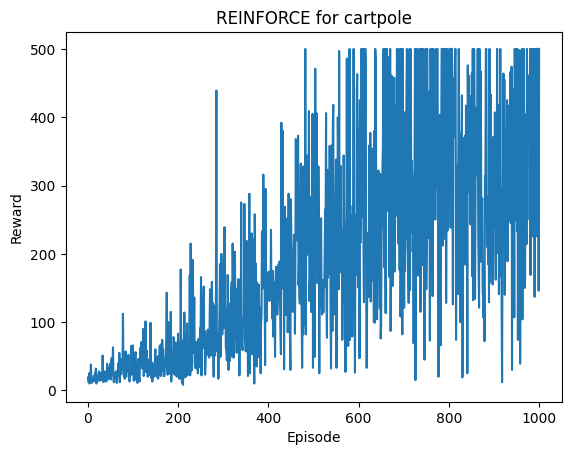

In [19]:
plt.plot(np.linspace(1, len(total_reward_reinforce), len(total_reward_reinforce)), total_reward_reinforce)

# Add labels and title
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("REINFORCE for cartpole")

# Display the plot
plt.show()

# REINFORCE with baseline

In [ ]:
# class StateValue(nn.Module):
#     def __init__(self, state_dim=4, hidden_dim=32):
#         super().__init__()

#         self.linear1 = nn.Linear(state_dim, hidden_dim)
#         self.linear3 = nn.Linear(hidden_dim, hidden_dim)
#         self.linear2 = nn.Linear(hidden_dim, 1)

#     def forward(self, x):
#         return self.linear2(self.linear3(self.linear1(x)))
# class StateValue(nn.Module):
#     """
#       - State-value approximation which is used for all the algorithms
#       - Policy prameterization is based on PPO paper
#     """

#     def __init__(self, p_dim=2, state_dim=4, hidden_dim=64):
#         super().__init__()
#         self.linear1 = nn.Linear(state_dim, hidden_dim)
#         # torch.nn.init.normal_(self.linear1.weight, mean=0.0, std=0.1)
#         self.linear2 = nn.Linear(hidden_dim, hidden_dim)
#         # torch.nn.init.normal_(self.linear2.weight, mean=0.0, std=0.1)
#         self.linear3 = nn.Linear(hidden_dim, hidden_dim)
#         # torch.nn.init.normal_(self.linear3.weight, mean=0.0, std=0.1)
#         self.linear4 = nn.Linear(hidden_dim, 1)
#         # torch.nn.init.normal_(self.linear4.weight, mean=0.0, std=0.1)
#         self.tanh = torch.nn.Tanh()

#     def forward(self, x):
#         x = self.tanh(self.linear1(x))
#         # x = self.tanh(self.linear2(x))
#         x = self.tanh(self.linear3(x))

#         return self.tanh(self.linear4(x))

# def state_values(state_param, states_seen):
#     st_vals = torch.zeros((len(states_seen)))
#     for i, st in enumerate(states_seen):
#         cur_val = state_param(st)
#         st_vals[i] = cur_val
#     return st_vals

class StateValue(nn.Module):
    def __init__(self, obs_dim, hidden=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden), nn.Tanh(),
            nn.Linear(hidden, hidden), nn.Tanh(),
            nn.Linear(hidden, 1)
        )

    def forward(self, x):
        return self.net(x).squeeze(-1)   # output shape: [batch]


# Solving Cartpole using REINFORCE with baseline

In [ ]:
env = gym.make("CartPole-v1")
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.n
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
episodes = 1000
discount_factor = 0.99
total_reward_reinforce_baseline = np.zeros(episodes)
sim_runs = 50
for sim in range(sim_runs):
  policy = PolicyGradient(act_dim, obs_dim)
  sv = StateValue(act_dim, obs_dim, hidden_dim=32)
  optimizer = optim.Adam(policy.parameters(), lr=1e-3)
  optimizer_sv = optim.Adam(sv.parameters(), lr=2e-3)
  returns_hist = []
  for ep in range(episodes):
      rw, logp, st, _ = gen_episode(env, policy, device)
      returns_hist.append(len(rw))
      R = discounted_rewards(rw, discount_factor)
      R = torch.as_tensor(R, dtype=torch.float32, device=device)
      st = torch.as_tensor(st, dtype=torch.float32, device=device)
      # R = (R - R.mean()) / (R.std() + 1e-8)
      state_value_approx = state_values(sv, st)
      # state_value_approx = (state_value_approx - state_value_approx.mean()) / (state_value_approx.std() + 1e-8)
      delta = R - state_value_approx
      delta = delta.detach()
      logp = torch.stack(logp)
      discounting = [discount_factor ** i for i in range(len(rw))]
      discounting = torch.as_tensor(discounting, dtype=torch.float32, device=device)
      loss = -(logp * delta).sum()
      optimizer.zero_grad()
      loss.backward()
      # nn.utils.clip_grad_norm_(policy.parameters(), 1.0)
      optimizer.step()

      # State-value function approximater update
      # state_value_approx = torch.stack(state_value_approx)
      loss_sv = -(delta * state_value_approx).sum()
      optimizer_sv.zero_grad()
      loss_sv.backward()
      # nn.utils.clip_grad_norm_(sv.parameters(), 1.0)
      optimizer_sv.step()
      if len(returns_hist) >= 100 and np.mean(returns_hist[-100:]) >= 475:
            total_reward_reinforce_baseline[ep:] += 500
            break
      total_reward_reinforce_baseline[ep] += len(rw)
  if sim % 5 == 0:
      print(sim)
total_reward_reinforce_baseline = total_reward_reinforce_baseline / sim_runs


0
5
10
15


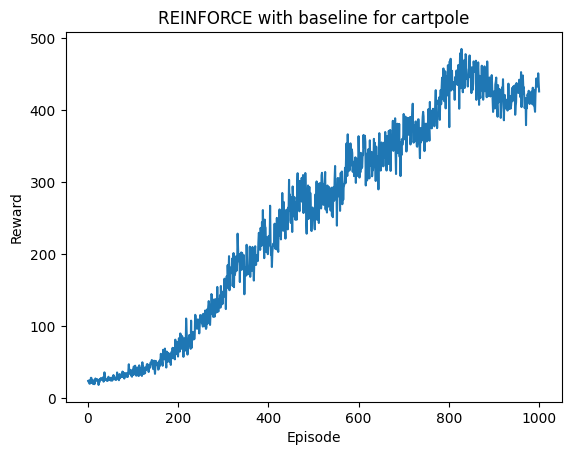

In [ ]:
plt.plot(np.linspace(1, len(total_reward_reinforce_baseline), len(total_reward_reinforce_baseline)), total_reward_reinforce_baseline)

# Add labels and title
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("REINFORCE with baseline for cartpole")

# Display the plot
plt.show()

# Key Take-aways:

- **Motivation for On-policy methods:** Off-policy methods converge faster but are computationally expensive and difficult to implement.
- **Methods:** Simplest approach is REINFORCE algorithm. Issue is high variance and actor-critic methods are developed to address the high variance issue.

# Key take-aways:
**On- vs. Off-policy motivation:**
- Off-policy methods (e.g. Q-learning, DQN, SAC) are more sample-efficient because they can reuse old data from replay buffers.
- But they are not necessarily more computationally expensive; in fact, on-policy methods often require more environment interactions (i.e., more compute in simulation).
- Off-policy methods can be harder to stabilize (divergence, distribution shift).
- On-policy methods (REINFORCE, PPO, A2C) are simpler conceptually, unbiased, and often more stable in practice — at the cost of discarding old trajectories.
  
**Methods:**
- REINFORCE = simplest on-policy algorithm. Direct policy gradient, unbiased, but high variance.
- Actor–Critic = introduces a value function (the critic) to reduce variance and improve stability.
- PPO / TRPO = further refinements that make actor–critic methods stable and scalable to large models (this is why PPO is the backbone of RLHF).

# On- vs Off-Policy: Key Take-aways

## Why On-policy?

**Off-policy (Q-learning, DQN, SAC)**

✅ More sample-efficient (reuse replay buffer).

⚠️ Can be harder to stabilize (distribution shift, divergence).

⚖️ Not inherently more “computationally expensive” — often cheaper per gradient step.

**On-policy (REINFORCE, A2C, PPO)**

✅ Simple & stable (fresh data, unbiased gradients).

❌ Less sample-efficient (must discard old trajectories).

🚀 Easier to scale to large policies (why PPO is used in RLHF).

## Algorithm lineage:

- REINFORCE → simplest on-policy policy gradient; high variance.
- Actor–Critic → adds a value function to reduce variance & improve learning.
- PPO / TRPO → clip or constrain updates for stability at scale.

# Actor-Critic with eligibility trace

In [ ]:
def discounted_advantage(rw, val_approx, discount_factor, history_decay, history_len):
    R = []
    for i in range(len(rw)):
        discounted_reward = 0
        for j in range(i, min(len(rw), history_len)):
            discounted_reward += (history_decay ** (j - i)) * (rw[j] + discount_factor * val_approx[j + 1] - val_approx[j])
        R.append(discounted_reward)
    return R

env = gym.make("CartPole-v1")
# env = gym.make("Acrobot-v1")
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.n
episodes = 1000
discount_factor = 0.99
history_decay = 0.99
total_reward = [0] * episodes
history_len = 150
sim_runs = 50
for _ in range(sim_runs):
    policy = Reinforce(act_dim, obs_dim, hidden_dim=64)
    sv = StateValue(state_dim=obs_dim, hidden_dim=64)
    optimizer = optim.Adam(policy.parameters(), lr=3e-4)
    optimizer_sv = optim.Adam(sv.parameters(), lr=3e-4)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    for ep in range(episodes):
        rw, logp, st, _ = gen_episode(env, policy, device)
        total_reward[ep] += len(rw)
        # R = discounted_rewards(rw, discount_factor)
        # R = torch.as_tensor(R, dtype=torch.float32, device=device)

        st = torch.as_tensor(st, dtype=torch.float32, device=device)
        # R = (R - R.mean()) / (R.std() + 1e-8)

        state_value_approx = state_values(sv, st)
        state_value_approx = torch.cat((state_value_approx, torch.unsqueeze(torch.tensor(0), 0)), dim=0)
        # state_value_approx = torch.as_tensor(state_value_approx, dtype=torch.float32, device=device)
        rw = torch.as_tensor(rw, dtype=torch.float32, device=device)
        # rw = torch.cat((rw, torch.unsqueeze(torch.tensor(0), 0)), dim=0)
        state_value_approx[-1] = 0
        delta = discounted_advantage(rw, state_value_approx, discount_factor, history_decay, history_len)
        delta = torch.as_tensor(delta, dtype=torch.float32, device=device)
        # print(state_value_approx.requires_grad, delta.requires_grad)
        # break
        logp = torch.stack(logp)
        # discounting = [discount_factor ** i for i in range(len(rw))]
        discounting = [1 ** i for i in range(len(rw))]
        discounting = torch.as_tensor(discounting, dtype=torch.float32, device=device)
        # delta = (delta - delta.mean()) / (delta.std() + 1e-8)
        # loss = -(discounting * logp * delta).mean()
        loss = -(logp * delta).mean()
        optimizer.zero_grad()
        loss.backward()
        # nn.utils.clip_grad_norm_(policy.parameters(), 1.0)
        optimizer.step()

        # State-value function approximater update
        # state_value_approx = torch.stack(state_value_approx)
        # loss_sv = (state_value_approx[:-1]).pow(2).mean()
        # delta.requires_grad = True
        loss_sv = -(delta * state_value_approx[:-1]).mean()
        optimizer_sv.zero_grad()
        loss_sv.backward()
        # nn.utils.clip_grad_norm_(sv.parameters(), 1.0)
        optimizer_sv.step()
total_reward = np.array(total_reward) / sim_runs

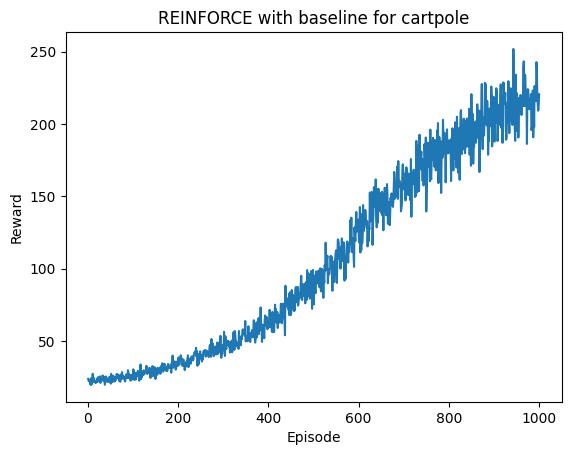

In [ ]:
plt.plot(np.linspace(1, len(total_reward), len(total_reward)), total_reward)

# Add labels and title
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("REINFORCE with baseline for cartpole")

# Display the plot
plt.show()

# Proximal policy optimization (PPO)



 - Imporves upon TRPO. Stability issue with TRPO covered in https://arxiv.org/pdf/2102.06234
 - PPO extends TRPO by replacing its hard KL-divergence constraint with a simpler clipped surrogate objective that approximates the trust region effect.

In [ ]:
def clip_ratio(p, p_old, adv, epsilon, device):
    loss_clip = torch.zeros(p.size(), device=device)
    for i in range(len(adv)):
        if adv[i] > 0:
            if p[i]/p_old[i] > 1 + epsilon:
                loss_clip[i] = min((p[i]/p_old[i]) * adv[i], (1 + epsilon) * adv[i])
            else:
                loss_clip[i] = (p[i]/p_old[i]) * adv[i]
        elif adv[i] < 0:
            if p[i]/p_old[i] < 1 - epsilon:
                loss_clip[i] = min((p[i]/p_old[i]) * adv[i], (1 - epsilon) * adv[i])
            else:
                loss_clip[i] = (p[i]/p_old[i]) * adv[i]
    return -loss_clip

In [ ]:
class PPO(nn.Module):
    def __init__(self, p_dim=2, state_dim=4, hidden_dim=64):
        super().__init__()
        self.linear1 = nn.Linear(state_dim, hidden_dim)
        torch.nn.init.normal_(self.linear1.weight, mean=0.0, std=0.1)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        torch.nn.init.normal_(self.linear2.weight, mean=0.0, std=0.1)
        self.linear3 = nn.Linear(hidden_dim, hidden_dim)
        torch.nn.init.normal_(self.linear3.weight, mean=0.0, std=0.1)
        self.linear4 = nn.Linear(hidden_dim, p_dim)
        torch.nn.init.normal_(self.linear4.weight, mean=0.0, std=0.1)
        self.tanh = torch.nn.Tanh()

    def forward(self, x):
        x = self.tanh(self.linear1(x))
        x = self.tanh(self.linear2(x))
        x = self.tanh(self.linear3(x))

        return self.linear4(x)

    def sample_action(self, probs):
        # probs = torch.tensor(p)
        categorical_dist = Categorical(probs)
        sample = categorical_dist.sample()

        return sample

In [ ]:
env = gym.make("CartPole-v1")
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.n
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
episodes = 1000
discount_factor = 0.99
epsilon = 0.1
sim_runs = 1
total_reward = [0] * episodes
for _ in range(sim_runs):
    policy = PPO(act_dim, obs_dim, hidden_dim=64)
    optimizer = optim.Adam(policy.parameters(), lr=1e-3)
    for ep in range(episodes):
        rw, logp, _, probs = gen_episode(env, policy, device)
        total_reward[ep] += len(rw)
        R = discounted_rewards(rw, discount_factor)
        R = torch.as_tensor(R, dtype=torch.float32, device=device)
        # R = (R - R.mean()) / (R.std() + 1e-8)
        logp = torch.stack(logp)
        probs = logp.exp()
        probs_old = probs.clone().detach()
        loss = clip_ratio(probs, probs_old, R, epsilon, device).mean()
        # print(loss)
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(policy.parameters(), 1.0)
        optimizer.step()
total_reward = np.array(total_reward) / sim_runs

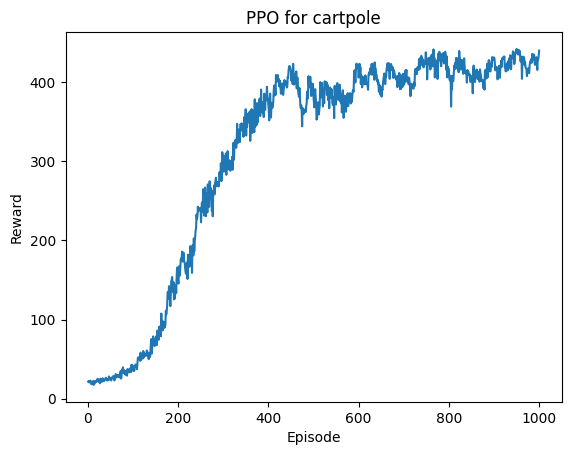

In [ ]:
plt.plot(np.linspace(1, len(total_reward), len(total_reward)), total_reward)

# Add labels and title
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("PPO for cartpole")

# Display the plot
plt.show()


# PPO with termination
- Terminate the program once max reward of 500 if found and assign value of 500 for the remaining episodes

In [ ]:
env = gym.make("CartPole-v1")
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.n
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
episodes = 1000
discount_factor = 0.99
epsilon = 0.1
sim_runs = 50
total_reward_terminate = [0] * episodes
for sim in range(sim_runs):
    policy = PPO(act_dim, obs_dim, hidden_dim=64)
    optimizer = optim.Adam(policy.parameters(), lr=1e-3)
    for ep in range(episodes):
        rw, logp, _, probs = gen_episode(env, policy, device)
        if len(rw) == 500:
            for idx in range(ep, episodes):
                total_reward_terminate[idx] += 500
            break
        total_reward_terminate[ep] += len(rw)
        R = discounted_rewards(rw, discount_factor)
        R = torch.as_tensor(R, dtype=torch.float32, device=device)
        # R = (R - R.mean()) / (R.std() + 1e-8)
        logp = torch.stack(logp)
        probs = logp.exp()
        probs_old = probs.clone().detach()
        loss = clip_ratio(probs, probs_old, R, epsilon, device).mean()
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(policy.parameters(), 1.0)
        optimizer.step()
total_reward_terminate = np.array(total_reward_terminate) / sim_runs

KeyboardInterrupt: 

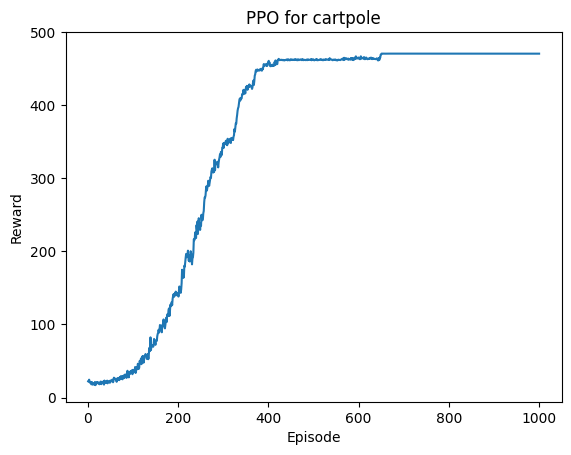

In [ ]:
plt.plot(np.linspace(1, len(total_reward_terminate), len(total_reward_terminate)), total_reward_terminate)

# Add labels and title
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("PPO for cartpole")
plt.yticks([0, 100, 200, 300, 400, 500])
# Display the plot
plt.show()


# REINFORCE for Acrobot environment

In [ ]:
env = gym.make("Acrobot-v1")
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.n
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
policy = Reinforce(act_dim, obs_dim).to(device)
optimizer = optim.Adam(policy.parameters(), lr=3e-3)
episodes = 1000
discount_factor = 0.99
total_reward = []
for ep in range(episodes):
    rw, logp, _, _ = gen_episode(env, policy, device)
    total_reward.append(len(rw))
    R = discounted_rewards(rw, discount_factor)
    R = torch.as_tensor(R, dtype=torch.float32, device=device)
    R = (R - R.mean()) / (R.std() + 1e-8)
    logp = torch.stack(logp)
    loss = -(logp * R).sum()
    optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_norm_(policy.parameters(), 1.0)
    optimizer.step()



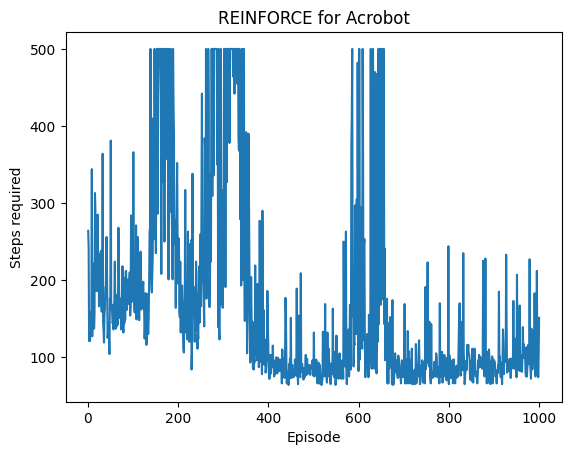

In [ ]:
plt.plot(np.linspace(1, len(total_reward), len(total_reward)), total_reward)

# Add labels and title
plt.xlabel("Episode")
plt.ylabel("Steps required")
plt.title("REINFORCE for Acrobot")

# Display the plot
plt.show()
